In [75]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import ast
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
import pickle

from keras.layers import Dense, LSTM, Dropout
from keras.models import Model, Sequential
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
## import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

## import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

## import the IBES analysts estimates data
estimates_df = pd.read_csv(
        '../Data/eikon_ibes_data_1995.csv',
        index_col = 0,
        parse_dates = True, 
)#.fillna(method = 'ffill').dropna(axis = 1, how = 'any')

In [3]:
# create a monthly date range 
dates = pd.date_range('1995-01', '2020-01', freq = 'BM').strftime('%Y-%m')

# # resample price data to weekly intervals starting in 2005
prices_df = prices_df.loc['1995-01-01':, :]
spx_df = spx_df.loc['1995-01-01':, :]

In [4]:
estimates_df.columns = [
    'RIC',
    'Number of Analysts', 
    'Earnings Per Share FY0 - Actual',
    'Earnings Per Share FY0 - Mean', 
    'Earnings Per Share FY1 - Mean',
    'Earnings Per Share FY2 - Mean', 
    'Earnings Per Share FQ0 - Actual',
    'Earnings Per Share FQ0 - Mean', 
    'Earnings Per Share FQ1 - Mean',
    'Earnings Per Share FQ2 - Mean', 
    'Earnings Per Share FQ3 - Mean',
    'Earnings Per Share FQ4 - Mean'
]

estimates_df.head()

,RIC,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean
1990-01-31,SK.N^E98,24.0,0.84667,0.83588,0.92667,1.10083,0.20000,0.23308,0.30143,0.22500,0.23750,0.24333
1990-01-31,CSCO.OQ,0.0,0.00118,NaN,NaN,NaN,0.00069,NaN,NaN,NaN,NaN,NaN
1990-01-31,EXPD.OQ,9.0,0.03906,0.03917,0.04861,0.05893,0.00417,0.00375,0.00531,0.00625,0.00625,0.00563
1990-01-31,CERN.OQ,3.0,0.00781,NaN,0.01667,0.01896,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,TAPb.N^D04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
## split the data into training and test data
train_start_date = '1995-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2019-12-31'

train_prices_df = prices_df[train_start_date:train_end_date]
test_prices_df = prices_df[test_start_date:test_end_date]

# train_returns_df = returns_df[train_start_date:train_end_date]
# test_returns_df = returns_df[test_start_date:test_end_date]

train_spx_df = spx_df[train_start_date:train_end_date]
test_spx_df = spx_df[test_start_date: test_end_date]

# train_spx_returns_df = spx_returns_df[train_start_date: train_end_date]
# test_spx_returns_df = spx_returns_df[test_start_date: test_end_date]

train_estimates_df = estimates_df[train_start_date:train_end_date]
test_estimates_df = estimates_df[test_start_date:test_end_date]

In [6]:
# quick check for NaN values
n_nan = 0
for df in [
#     train_returns_df, 
#     test_returns_df, 
#     train_spx_returns_df, 
#     test_spx_returns_df
]:
    n_nan += df.isna().sum().values.sum()
    if n_nan > 0: 
        print(n_nan, ' NaN values exist')

In [7]:
map_df.loc[map_df['ISIN'] == 'US98389B1008', :] # Most representative according to AE

,RIC,SEDOL,ISIN,CUSIP,Company Common Name,GICS Sector Name,GICS Industry Name
Instrument,,,,,,,
XEL.OQ,XEL.OQ,2614807,US98389B1008,98389B100,Xcel Energy Inc,Utilities,Electric Utilities


In [8]:
start_date = '2010-01-01'
end_date = '2019-12-31'

In [9]:
price_df = prices_df.loc[start_date:end_date, 'US98389B1008']
price_df = price_df.resample('M').last()
price_df

Code
2010-01-31    20.780001
2010-02-28    20.809999
2010-03-31    21.200001
2010-04-30    21.750000
2010-05-31    20.490000
                ...    
2019-08-31    64.220001
2019-09-30    64.889999
2019-10-31    63.509998
2019-11-30    61.490002
2019-12-31    63.490002
Freq: M, Name: US98389B1008, Length: 120, dtype: float32

In [10]:
top_co_df = copy.deepcopy(estimates_df.loc[estimates_df['RIC'] == 'SO.N', :])
top_co_df.drop('RIC', axis = 1, inplace = True)
top_co_df = top_co_df.loc[start_date:end_date]

In [11]:
price_df.shape, top_co_df.shape

((120,), (120, 11))

In [12]:
top_co_df['price'] = price_df.values
top_co_df['eps_fq0_surprise'] = top_co_df['Earnings Per Share FQ0 - Actual'] - top_co_df['Earnings Per Share FQ0 - Mean']
top_co_df['eps_fy0_surprise'] = top_co_df['Earnings Per Share FY0 - Actual'] - top_co_df['Earnings Per Share FY0 - Mean']

In [13]:
top_co_df

,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean,price,eps_fq0_surprise,eps_fy0_surprise
2010-01-29,20.0,2.32,2.31075,2.36737,2.53533,0.31,0.29527,0.43800,0.61971,1.03567,0.28880,20.780001,0.01473,0.00925
2010-02-26,20.0,2.32,2.31075,2.35053,2.51375,0.31,0.29527,0.43333,0.61167,0.98400,0.33000,20.809999,0.01473,0.00925
2010-03-31,21.0,2.32,2.31075,2.34950,2.51059,0.31,0.29527,0.43125,0.61000,0.99286,0.32000,21.200001,0.01473,0.00925
2010-04-30,23.0,2.32,2.31075,2.37364,2.52095,0.60,0.43688,0.58455,0.97778,0.28333,0.47250,21.750000,0.16312,0.00925
2010-05-31,23.0,2.32,2.31075,2.38773,2.52238,0.60,0.43688,0.57455,0.98200,0.27667,0.50200,20.490000,0.16312,0.00925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30,20.0,3.07,3.04460,3.03033,3.15453,0.80,0.72633,1.13893,0.41407,0.71157,0.76629,64.220001,0.07367,0.02540
2019-09-30,20.0,3.07,3.04460,3.03850,3.15453,0.80,0.72633,1.14393,0.40836,0.71729,0.76914,64.889999,0.07367,0.02540
2019-10-31,20.0,3.07,3.04460,3.08985,3.17330,1.34,1.14413,0.32814,0.72771,0.76143,1.18983,63.509998,0.19587,0.02540
2019-11-29,19.0,3.07,3.04460,3.09321,3.17553,1.34,1.14413,0.31939,0.73633,0.76217,1.18667,61.490002,0.19587,0.02540


In [14]:
top_co_df = top_co_df.fillna(method = 'ffill') 
top_co_df.isna().sum()

Number of Analysts                 0
Earnings Per Share FY0 - Actual    0
Earnings Per Share FY0 - Mean      0
Earnings Per Share FY1 - Mean      0
Earnings Per Share FY2 - Mean      0
Earnings Per Share FQ0 - Actual    0
Earnings Per Share FQ0 - Mean      0
Earnings Per Share FQ1 - Mean      0
Earnings Per Share FQ2 - Mean      0
Earnings Per Share FQ3 - Mean      0
Earnings Per Share FQ4 - Mean      0
price                              0
eps_fq0_surprise                   0
eps_fy0_surprise                   0
dtype: int64

___
## Train Test Split

In [15]:
# 5 years of test data
train_len = top_co_df.shape[0] - 60

train = top_co_df.iloc[:train_len]
test = top_co_df.iloc[train_len:]

train.shape, test.shape

((60, 14), (60, 14))

___
## Scale Data

In [16]:
scaler = MinMaxScaler()

scaler.fit(train) # WE ONLY FIT TO TRAINING DATA
scaled_train = scaler.transform(train) # each column ranges from 0 to 1
scaled_test = scaler.transform(test)

scaled_train.max(), scaled_test.max()

(1.0000000000000002, 2.8775116156060445)

___
## Time Series Generator

In [17]:
n_input = 12
n_cols = scaled_train.shape[1]

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

___
## Hyperparameter Search

In [18]:
def hyper_search(
    n_input, 
    n_nodes_list, 
    lr = 0.0001,
    rate_dropout = 0.0, 
    act_funct = 'relu',  
    batch_size = 1,
    epochs = 100,
    patience = 3, 
    early_stop_bool = True
):

    ## Time-Series Generator
    n_cols = scaled_train.shape[1]
    generator = TimeseriesGenerator(scaled_train, scaled_train[:, 11], length = n_input, batch_size = 1)
    val_generator = TimeseriesGenerator(scaled_test, scaled_test[:, 11], length = n_input, batch_size = 1)


    ## Build LSTM model
    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer], 
                input_shape = (n_input, n_cols)
            ))
        else:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer]
            ))
        if rate_dropout != 0.0:
            model.add(Dropout(rate = rate_dropout))
    
    model.add(Dense(1))
    opt = Adam(learning_rate = lr)
    model.compile(optimizer = opt, loss = 'mean_squared_error')


    ## Fit LSTM model
    if early_stop_bool:
        early_stopping = EarlyStopping(monitor = 'loss', patience = patience)
        model.fit_generator(
            generator, 
            epochs = epochs, 
            validation_data = val_generator,
            callbacks = [early_stopping]
        )
    else: 
        model.fit_generator(
            generator, 
            epochs = epochs,
            validation_data = val_generator
        )

    ## Generate Predictions
    test_predictions = []
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_cols))
    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred) 
        current_batch = np.append(current_batch[:, 1:, :],[[scaled_test[i]]], axis = 1)
        
    test_predictions_temp = np.zeros((len(test), 14))
    test_predictions_temp[:, 11] = test_predictions
    true_predictions = scaler.inverse_transform(test_predictions_temp)

    return generator, model, true_predictions

Due to the time-series element using the scikit-learn grid search function was not feasible. It appears from the available documentation, that this is not easily achieved with the function. As a result, a customised search function was created instead.

Additionally, the size of the data set for the LSTM modelling is much smaller than the AE due to the monthly frequency of the analyst estimates data. This issue, combined with the pequiliarities of testing time-series data meant that cross-validation was not performed.

In [19]:
n_nodes_list = [(100,), (300,), (500,), (100, 100, 100), (300, 300, 300), (500, 500, 500), (300, 300, 300, 300, 300)]
lr = [0.0000001, 0.000001, 0.00001, 0.0001]
n_input = [3, 6, 12, 24]

In [27]:
import_grid_results = True

if import_grid_results:
    
    filename = 'model/lstm_grid_result_2020_08_31.pkl' # or change the date

    infile = open(filename,'rb')
    grid_results_dict = pickle.load(infile)
    infile.close()
    
else:

    loop = 1
    total_loops = len(n_nodes_list) * len(lr) * len(n_input)
    print(total_loops)

    grid_results_dict = {}

    for a in n_input:
        for b in n_nodes_list:
            for c in lr:
                grid_results_dict[f'{a}_{b}_{c}'] = hyper_search(
                    n_input = a, 
                    n_nodes_list = b, 
                    lr = c,
                )

                print('\n\n\nPercentage Complete: ', round(loop / total_loops, 4) * 100, '%\n\n\n')
                loop += 1

In [28]:
export_grid_search = False
today = datetime.now().strftime('%Y_%m_%d')

if export_grid_search:
    
    f = open(f'model/lstm_grid_result_{today}.pkl', 'wb')
    pickle.dump(grid_results_dict, f)
    f.close()

In [51]:
mse_df = pd.DataFrame()

for k, v in grid_results_dict.items():
    mse = mean_squared_error(test.iloc[:, 11].values, v[2][:, 11])
    mse_df.loc[k, 'mse'] = mse  

mse_df.sort_values('mse', inplace = True)
mse_df.head(10)
mse_df.to_csv('../Data/lstm_grid_results2.csv')

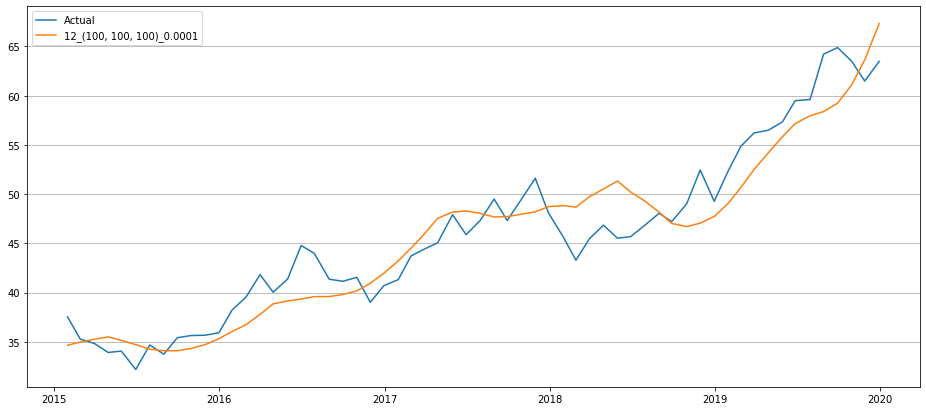

In [52]:
plt.figure(figsize = (16, 7))
plt.plot(test.iloc[:, 11], label = 'Actual')
for combo in mse_df.index[:1]:
    plt.plot(test.index, grid_results_dict[combo][2][:, 11], label = combo)
    
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

In [53]:
predicted = grid_results_dict[mse_df.index[0]][2][:, 11]
actual = test.iloc[:, 11]

print('The R2 score is:\t{:0.3f}'.format(r2_score(actual, predicted)))

The R2 score is:	0.891


In [54]:
mse_df.index[0]

'12_(100, 100, 100)_0.0001'

In [55]:
import_model_wo_reg = False

if import_model_wo_reg:
    model = load_model('model/ae_model_wo_reg_2020_08_21.h5') # change date as required

else: 
    
    generator, model, true_predictions = hyper_search(
        n_input = 12, 
        n_nodes_list = (100, 100, 100), 
        lr = 0.0001,
        rate_dropout = 0.0, 
        act_funct = 'relu',  
        batch_size = 1,
        epochs = 100,
        patience = 3, 
        early_stop_bool = False
    )

Epoch 1/100
48/48 [==============================] - 2s 37ms/step - loss: 0.1890 - val_loss: 4.5868
Epoch 2/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0246 - val_loss: 1.4917
Epoch 3/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0094 - val_loss: 1.9325
Epoch 4/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0079 - val_loss: 1.1698
Epoch 5/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0082 - val_loss: 1.8467
Epoch 6/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0073 - val_loss: 1.1452
Epoch 7/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0070 - val_loss: 1.4468
Epoch 8/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0063 - val_loss: 1.2896
Epoch 9/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0060 - val_loss: 1.2691
Epoch 10/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0060 - val_loss: 1.0027

KeyboardInterrupt: 

In [ ]:
export_model_wo_reg = True

if export_model_wo_reg:
    model.save(f'model/lstm_model_wo_reg_{today}.h5')

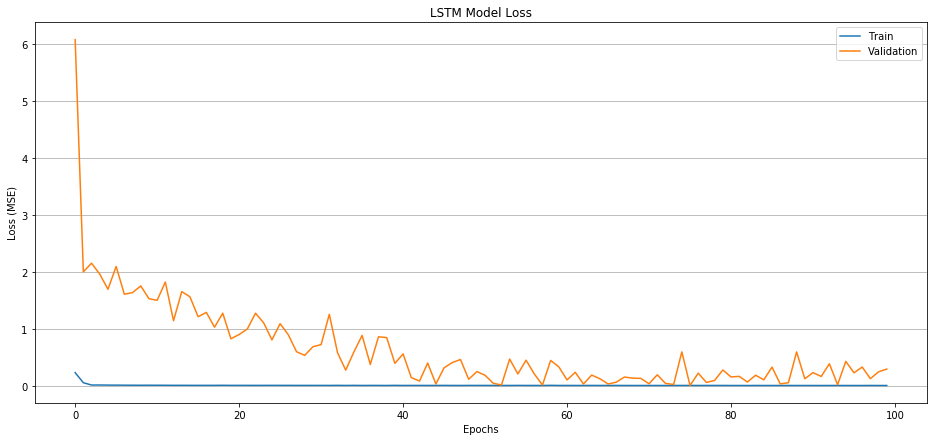

In [43]:
plt.figure(figsize = (16,7))
plt.plot(pd.Series(model.history.history['loss']), label = 'Train')
plt.plot(pd.Series(model.history.history['val_loss']), label = 'Validation')
plt.legend()
plt.title('LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.grid(axis = 'y')
plt.show()

This model looks awful, but some regularisation could potentially improve it further. Using a dropout rate will be tested with the LSTM model

## Retrain the model with Regularisation this time

One approach is to use different dropout rates to see if that reduces the variance

In [44]:
do_rates = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35]

In [56]:
lstm_dropout_search_dict = {}

for rate in do_rates:

    lstm_dropout_search_dict[rate] = hyper_search(
        n_input = 12, 
        n_nodes_list = (100, 100, 100,), 
        lr = 0.0001,
        rate_dropout = rate, 
        act_funct = 'relu',  
        batch_size = 1,
        epochs = 100,
        patience = 3, 
        early_stop_bool = False
    )

Epoch 1/100
48/48 [==============================] - 2s 37ms/step - loss: 0.2058 - val_loss: 5.2217
Epoch 2/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0279 - val_loss: 1.3131
Epoch 3/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0114 - val_loss: 1.5115
Epoch 4/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0098 - val_loss: 1.9475
Epoch 5/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0101 - val_loss: 1.8834
Epoch 6/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0083 - val_loss: 1.7346
Epoch 7/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0084 - val_loss: 1.6336
Epoch 8/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 1.6525
Epoch 9/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0089 - val_loss: 0.9110
Epoch 10/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0065 - val_loss: 1.0836

48/48 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 1.1455e-05
Epoch 83/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.1324
Epoch 84/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.1174
Epoch 85/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.2177
Epoch 86/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 0.4757
Epoch 87/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 0.1461
Epoch 88/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 89/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0691
Epoch 90/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0194
Epoch 91/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.1838

48/48 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 1.3532
Epoch 45/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 1.0236
Epoch 46/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0042 - val_loss: 1.2670
Epoch 47/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - val_loss: 0.9650
Epoch 48/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 1.3087
Epoch 49/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0045 - val_loss: 1.2703
Epoch 50/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 1.2770
Epoch 51/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0059 - val_loss: 0.9462
Epoch 52/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0044 - val_loss: 1.1474
Epoch 53/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 1.1714
Epo

48/48 [==============================] - 1s 13ms/step - loss: 0.0122 - val_loss: 1.3990
Epoch 7/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0134 - val_loss: 1.3307
Epoch 8/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0173 - val_loss: 1.2197
Epoch 9/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0125 - val_loss: 1.3284
Epoch 10/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0153 - val_loss: 1.5691
Epoch 11/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0104 - val_loss: 0.8612
Epoch 12/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0112 - val_loss: 1.3340
Epoch 13/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0091 - val_loss: 1.4998
Epoch 14/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0074 - val_loss: 1.4164
Epoch 15/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0145 - val_loss: 0.7027
Epoch 

48/48 [==============================] - 1s 13ms/step - loss: 0.0049 - val_loss: 0.5978
Epoch 69/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0047 - val_loss: 0.5858
Epoch 70/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0051 - val_loss: 0.1493
Epoch 71/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 0.6186
Epoch 72/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.6034
Epoch 73/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0061 - val_loss: 0.1818
Epoch 74/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0086 - val_loss: 1.1750
Epoch 75/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 1.0311
Epoch 76/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0056 - val_loss: 0.4556
Epoch 77/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.7458
Epo

48/48 [==============================] - 1s 13ms/step - loss: 0.0090 - val_loss: 1.8353
Epoch 31/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0112 - val_loss: 1.5983
Epoch 32/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0158 - val_loss: 1.0099
Epoch 33/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0112 - val_loss: 1.4280
Epoch 34/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0103 - val_loss: 1.9105
Epoch 35/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 1.4274
Epoch 36/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 1.2202
Epoch 37/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0092 - val_loss: 1.7165
Epoch 38/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0084 - val_loss: 1.8445
Epoch 39/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 1.3524
Epo

In [57]:
lstm_dropout_search_dict

{0.01: (<keras.preprocessing.sequence.TimeseriesGenerator at 0x7fcff480c290>,
  array([[ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
           2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
           1.80260000e-01,  1.91250000e-01,  2.41830000e-01,
           2.75560000e-01,  2.83830000e-01,  3.56229858e+01,
          -4.28700000e-02, -1.23000000e-03],
         [ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
           2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
           1.80260000e-01,  1.91250000e-01,  2.41830000e-01,
           2.75560000e-01,  2.83830000e-01,  3.60571566e+01,
          -4.28700000e-02, -1.23000000e-03],
         [ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
           2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
           1.80260000e-01,  1.91250000e-01,  2.41830000e-01,
           2.75560000e-01,  2.83830000e-01,  3.63177756e+01,
          -4.28700000e-02, -1.23000000e-03],
         [ 2.00000000e+01,  2.32000000e+00,  2.31075000

In [58]:
bias_variance_df = pd.DataFrame()

for k, v in lstm_dropout_search_dict.items(): 

    bias_variance_df.loc[k, 'train_error'] = v[1].history.history['loss'][-1]
    bias_variance_df.loc[k, 'test_error'] = v[1].history.history['val_loss'][-1]
    bias_variance_df.loc[k, 'difference'] = (
        np.abs(v[1].history.history['loss'][-1] - v[1].history.history['val_loss'][-1])
    )
    
    # adds the model without any regularisation
    bias_variance_df.loc['None', :] = [
        model.history.history['loss'][-1],
        model.history.history['val_loss'][-1],
        model.history.history['val_loss'][-1] - model.history.history['loss'][-1]
    ]

In [59]:
bias_variance_df.index = bias_variance_df.index.map(str)
bias_variance_df = bias_variance_df.sort_values('test_error')

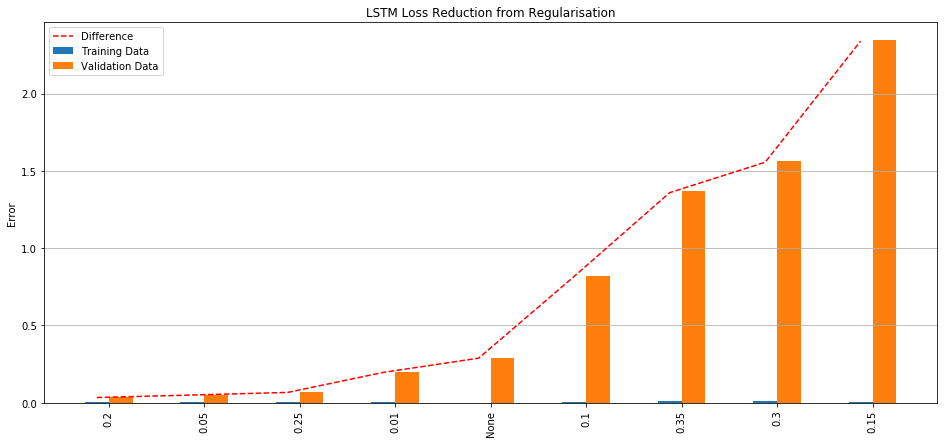

In [60]:
ind = np.arange(bias_variance_df.shape[0])
width = 0.25       

plt.figure(figsize = (16, 7))
plt.bar(ind, bias_variance_df['train_error'], width, label = 'Training Data')
plt.bar(ind + width, bias_variance_df['test_error'], width, label = 'Validation Data')
# plt.bar(ind + width * 2, bias_variance_df['difference'], width, label = 'Difference')
plt.plot(bias_variance_df['difference'], label = 'Difference', color = 'r', linestyle = '--')

plt.ylabel('Error')
plt.title('LSTM Loss Reduction from Regularisation')

plt.xticks(ind + width / 2, bias_variance_df.index, rotation = 90)
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show() 

Based on the above chart, a dropout rate of 25% produces the lowest test error. At this rate, the training error is marginally worse than having no dropout rate. However, it looks like the improvement in the test error outweighs the slight deterioration in training error. It can therefore be said that adding a dropout helps improve the model generalisation. 

In [61]:
best_do_rate = bias_variance_df.sort_values('test_error').index[0]
best_do_rate

'0.2'

In [62]:
best_do_rate = bias_variance_df.sort_values('test_error').index[0]
model_low_test_reg = lstm_dropout_search_dict[float(best_do_rate)][1]
model_low_test_reg.save(f'model/lstm_model_w_low_test_reg_{today}.h5')

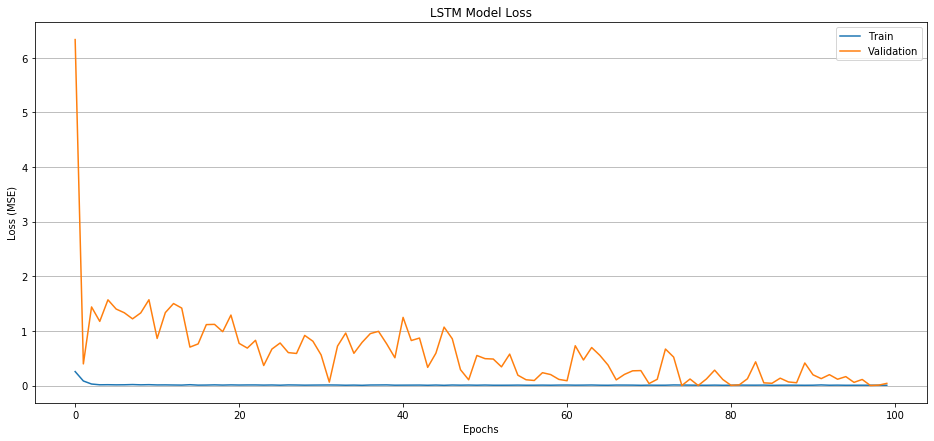

In [63]:
plt.figure(figsize = (16,7))
plt.plot(pd.Series(model_low_test_reg.history.history['loss']), label = 'Train')
plt.plot(pd.Series(model_low_test_reg.history.history['val_loss']), label = 'Validation')
plt.legend()
plt.title('LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.grid(axis = 'y')
plt.show()

In [64]:
model_low_test_reg_results = lstm_dropout_search_dict[float(best_do_rate)][2]

In [65]:
model_low_test_reg_results

array([[ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
         2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
         1.80260000e-01,  1.91250000e-01,  2.41830000e-01,
         2.75560000e-01,  2.83830000e-01,  3.52158118e+01,
        -4.28700000e-02, -1.23000000e-03],
       [ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
         2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
         1.80260000e-01,  1.91250000e-01,  2.41830000e-01,
         2.75560000e-01,  2.83830000e-01,  3.54337751e+01,
        -4.28700000e-02, -1.23000000e-03],
       [ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
         2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
         1.80260000e-01,  1.91250000e-01,  2.41830000e-01,
         2.75560000e-01,  2.83830000e-01,  3.58113467e+01,
        -4.28700000e-02, -1.23000000e-03],
       [ 2.00000000e+01,  2.32000000e+00,  2.31075000e+00,
         2.34950000e+00,  2.51059000e+00,  1.80000000e-01,
         1.80260000e-01,  1.91250000e-01,  2.

In [70]:
rolling_test = test.iloc[:, 11].rolling(3).mean()
top_params = mse_df.index[0]

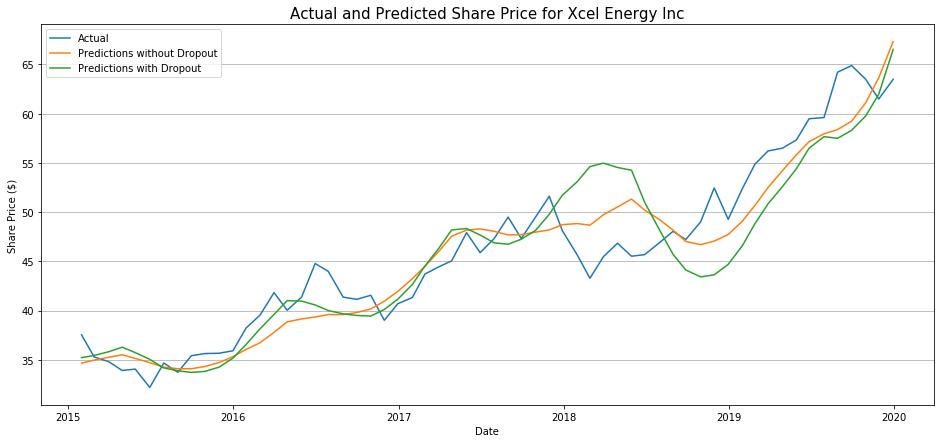

In [73]:
plt.figure(figsize = (16, 7))
plt.plot(test.iloc[:, 11], label = 'Actual')
plt.plot(test.index, grid_results_dict[top_params][2][:, 11], label = 'Predictions without Dropout')
plt.plot(test.index, model_low_test_reg_results[:, 11], label = 'Predictions with Dropout')
    
plt.title('Actual and Predicted Share Price for Xcel Energy Inc', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('Share Price ($)')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

In [76]:
t_stat, p_val = stats.ttest_ind(test.iloc[:, 11], grid_results_dict[top_params][2][:, 11])
t_stat_reg, p_val_reg = stats.ttest_ind(test.iloc[:, 11], model_low_test_reg_results[:, 11])

In [77]:
t_stat, p_val

(0.30081749130288976, 0.764083059210901)

In [79]:
t_stat_reg, p_val_reg

(0.2822768348487511, 0.7782257537752713)

In [80]:
r2 = r2_score(test.iloc[:, 11], grid_results_dict[top_params][2][:, 11])
r2_reg = r2_score(test.iloc[:, 11], model_low_test_reg_results[:, 11])

In [81]:
r2, r2_reg

(0.8913513881647348, 0.7788177511437095)